In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline

In [6]:
aapl = pd.read_csv('AAPL_CLOSE', index_col = 'Date', parse_dates=True)
cisco = pd.read_csv('CISCO_CLOSE', index_col = 'Date', parse_dates=True)
ibm = pd.read_csv('IBM_CLOSE', index_col = 'Date', parse_dates=True)
amzn = pd.read_csv('AMZN_CLOSE', index_col = 'Date', parse_dates=True)

In [7]:
stocks = pd.concat([aapl, cisco, ibm, amzn], axis = 1)
stocks.columns=['aapl', 'cisco', 'ibm', 'amzn']

In [8]:
stocks.head()

,aapl,cisco,ibm,amzn
Date,,,,
2012-01-03,53.063218,15.752778,160.830881,179.03
2012-01-04,53.348386,16.057180,160.174781,177.51
2012-01-05,53.940658,15.997991,159.415086,177.61
2012-01-06,54.504543,15.938801,157.584912,182.61
2012-01-09,54.418089,16.040268,156.764786,178.56


In [13]:
stocks.pct_change(1).mean()


aapl     0.000750
cisco    0.000599
ibm      0.000081
amzn     0.001328
dtype: float64

In [10]:
stocks.pct_change(1).corr()

,aapl,cisco,ibm,amzn
aapl,1.000000,0.301990,0.297498,0.235487
cisco,0.301990,1.000000,0.424672,0.284470
ibm,0.297498,0.424672,1.000000,0.258492
amzn,0.235487,0.284470,0.258492,1.000000


In [14]:
log_rets= np.log(stocks/stocks.shift(1))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f356b391ef0>,
      dtype=object)

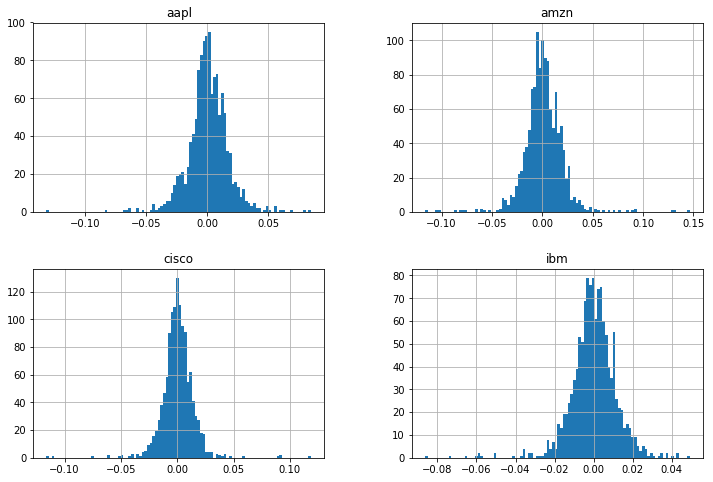

In [16]:
log_rets.hist(bins=100, figsize=(12,8))

In [17]:
log_rets.mean()

aapl     0.000614
cisco    0.000497
ibm      0.000011
amzn     0.001139
dtype: float64

In [20]:
log_rets.cov()*252

,aapl,cisco,ibm,amzn
aapl,0.068326,0.017854,0.014464,0.018986
cisco,0.017854,0.051381,0.018029,0.019956
ibm,0.014464,0.018029,0.035203,0.014939
amzn,0.018986,0.019956,0.014939,0.094470


In [57]:

# np.random.seed(101)
# weights = np.array(np.random.random(4))
# print('Random Weights')
# print(weights)
# print('Rebalance')
# weights = weights/np.sum(weights)
# print(weights)
#     # Expected Return
# print('Expected portfolio returns')
# exp_ret = np.sum((log_rets.mean()* weights)*252)
# print(exp_ret)
#     #Expected Volatility
# print('Expected Volatility')
# exp_volatility = np.sqrt((np.dot(weights.T, np.dot(log_rets.cov()*252, weights))))
# print(exp_volatility )

# print('Sharpe Ratio')
# SR = exp_ret/exp_volatility
# print(SR)

In [58]:
num_of_ports = 5000
all_weights=np.zeros((num_of_ports, len(stocks.columns)))
ret_arr = np.zeros(num_of_ports)
vol_arr = np.zeros(num_of_ports)
sharpe_array = np.zeros(num_of_ports)

for index in range(num_of_ports):
    weights = np.array(np.random.random(4))
    weights = weights/np.sum(weights)
    all_weights[index,:]= weights
    ret_arr[index] = np.sum((log_rets.mean()* weights)*252)
    vol_arr[index] = np.sqrt((np.dot(weights.T, np.dot(log_rets.cov()*252, weights))))
    sharpe_array[index] = ret_arr[index]/vol_arr[index]

In [40]:
sharpe_array.max()

1.0303260551271067

In [41]:
sharpe_array.argmax()

1419

In [65]:
all_weights[sharpe_array.argmax(),:]

array([0.26122899, 0.17752935, 0.0053286 , 0.55591305])

In [66]:
max_sr_return = ret_arr[sharpe_array.argmax()]
max_sr_vol= vol_arr[sharpe_array.argmax()]

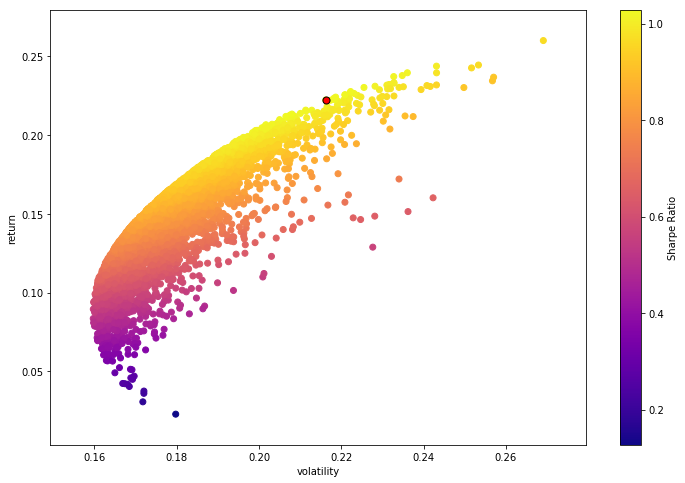

In [67]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr, ret_arr, c=sharpe_array, cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('volatility')
plt.ylabel('return')

plt.scatter(max_sr_vol, max_sr_return , c ='red', s=50, edgecolors='black')

In [88]:
def get_ret_vol_sr(weights):
    weights = np.array(weights)
    ret = np.sum(log_rets.mean() * weights) *252
    vol= np.sqrt(np.dot(weights.T, np.dot(log_rets.cov()*252,weights)))
    sr = ret/vol
    return np.array([ret,vol, sr])

In [89]:
from scipy.optimize import minimize

In [90]:
def negative_sharpe(weights): 
    return get_ret_vol_sr(weights)[2]*-1

In [91]:
def check_sum(weights): 
    return np.sum(weights)-1

In [92]:
cons=({'type':'eq', 'fun':check_sum})

In [93]:
bounds=((0,1),(0,1),(0,1),(0,1))
init_guess = [0.25,0.25,0.25,0.25]

In [94]:
opt_results = minimize(negative_sharpe, init_guess, method='SLSQP', bounds = bounds, constraints = cons)

In [95]:
opt_results.x

array([2.66289774e-01, 2.04189831e-01, 7.52707358e-17, 5.29520395e-01])

In [96]:
get_ret_vol_sr(opt_results.x)

array([0.21885915, 0.21233683, 1.03071687])

In [98]:
#efficient frontier

frontier_y = np.linspace(0,0.3, 100)

In [106]:
def minimize_volatility(weights):
    return get_ret_vol_sr(weights)[1]

In [107]:
frontier_volatility=[]
for possible_return in frontier_y:
    cons = ({'type': 'eq', 'fun': check_sum}, {'type':'eq', 'fun': lambda w: get_ret_vol_sr(w)[0]- possible_return})
    result = minimize(minimize_volatility, init_guess, method='SLSQP', bounds = bounds, constraints=cons)
    frontier_volatility.append(result['fun'])

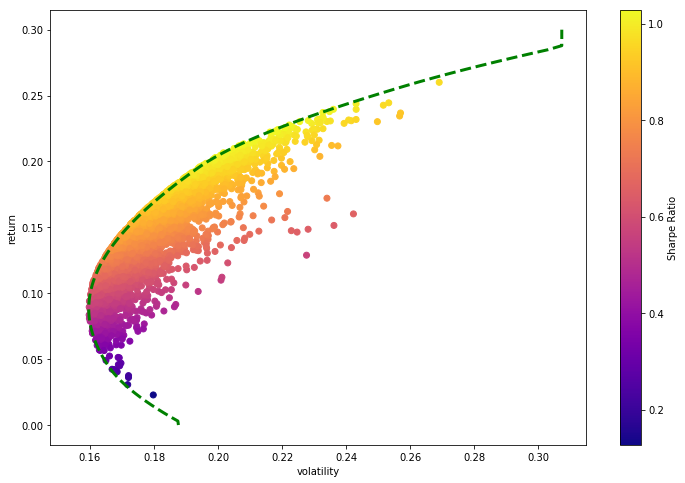

In [112]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr, ret_arr, c=sharpe_array, cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('volatility')
plt.ylabel('return')

plt.plot(frontier_volatility, frontier_y, 'g--', linewidth=3)